In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from collections import Counter
from nltk import ngrams

In [7]:
data = pd.read_csv("Data/GamesData.csv", usecols=["content", "score", "year", "game_name"])
data

,game_name,content,score,year
0,Garena Free Fire,Gunslinger meets battle royale! The developers...,5,2025
1,Garena Free Fire,Free Fire is a really fun and addictive battle...,4,2025
2,Garena Free Fire,I've been aware of this game for quite a while...,5,2025
3,Garena Free Fire,The game has the potential to be great. Howeve...,3,2019
4,Garena Free Fire,I personally find this game to be very enterta...,3,2019
...,...,...,...,...
2042995,Homescapes,Very boring. A lot of talk not enough action,1,2019
2042996,Homescapes,I love this house just wish the levels were ea...,4,2022
2042997,Homescapes,love this game only some of the levels seem im...,5,2019
2042998,Homescapes,Good game but requires in game payments which ...,3,2020


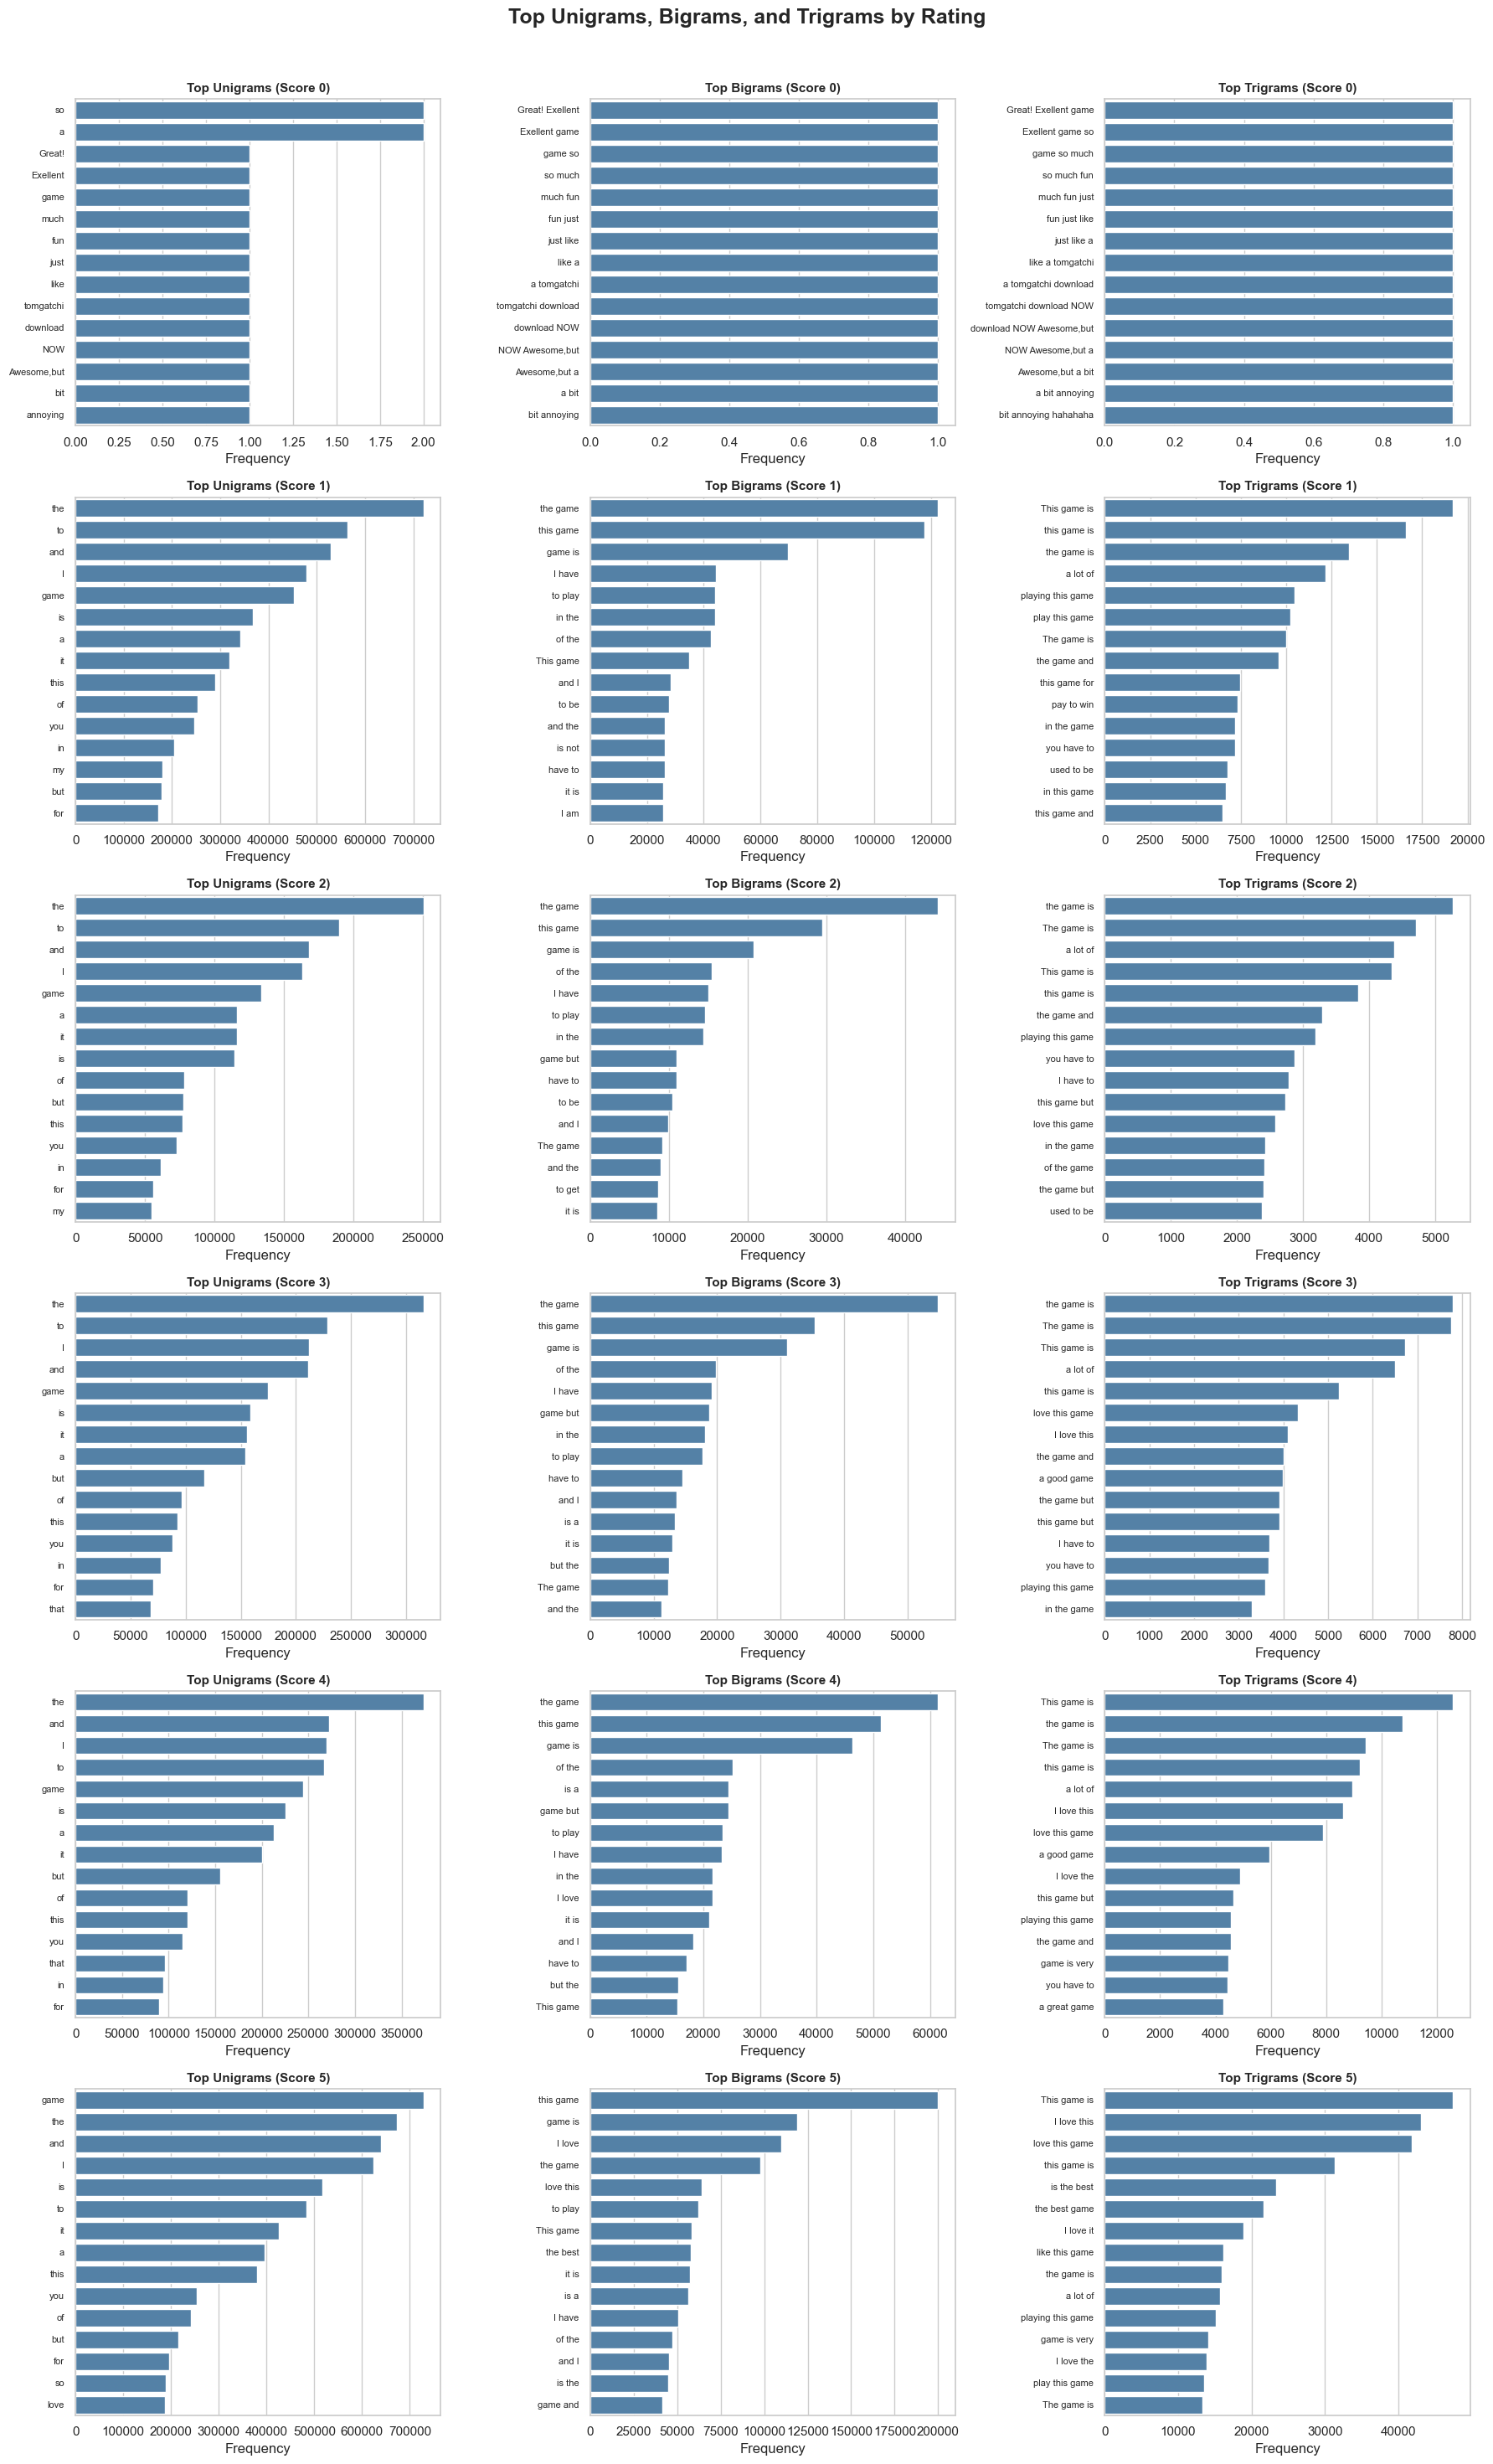

In [6]:
# --- Setup ---
sns.set(style="whitegrid")

# ensure 'score' column is numeric
data["score"] = pd.to_numeric(data["score"], errors="coerce")

# get sorted unique ratings (e.g. [1,2,3,4,5])
ratings = sorted(data["score"].dropna().unique())
n_scores = len(ratings)

# create subplot grid: one row per rating, 3 columns for unigram/bigram/trigram
fig, axes = plt.subplots(n_scores, 3, figsize=(18, 5 * n_scores))
if n_scores == 1:
    axes = [axes]  # handle case with only one rating

# --- Generate n-grams and plots per rating ---
for row, score in enumerate(ratings):
    df_subset = data[data["score"] == score]
    words = " ".join(df_subset["content"].dropna()).split()

    # store results for each n
    ngram_dfs = []

    for n, label in zip([1, 2, 3], ["Unigram", "Bigram", "Trigram"]):
        ngram_counts = Counter(ngrams(words, n))
        top_ngrams = ngram_counts.most_common(15)
        df_ngram = pd.DataFrame(top_ngrams, columns=["ngram", "count"])
        df_ngram["ngram"] = df_ngram["ngram"].apply(lambda x: " ".join(x))
        df_ngram["type"] = label
        ngram_dfs.append(df_ngram)

    ngram_df = pd.concat(ngram_dfs, ignore_index=True)

    # plot each n-gram type in separate column
    for col, label in enumerate(["Unigram", "Bigram", "Trigram"]):
        ax = axes[row][col] if n_scores > 1 else axes[col]
        subset = ngram_df[ngram_df["type"] == label].sort_values("count", ascending=False)

        sns.barplot(y="ngram", x="count", data=subset, ax=ax, color="steelblue")
        ax.set_title(f"Top {label}s (Score {score})", fontsize=11, fontweight="bold")
        ax.set_xlabel("Frequency")
        ax.set_ylabel("")
        ax.tick_params(axis='y', labelsize=8)

plt.suptitle("Top Unigrams, Bigrams, and Trigrams by Rating", fontsize=18, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


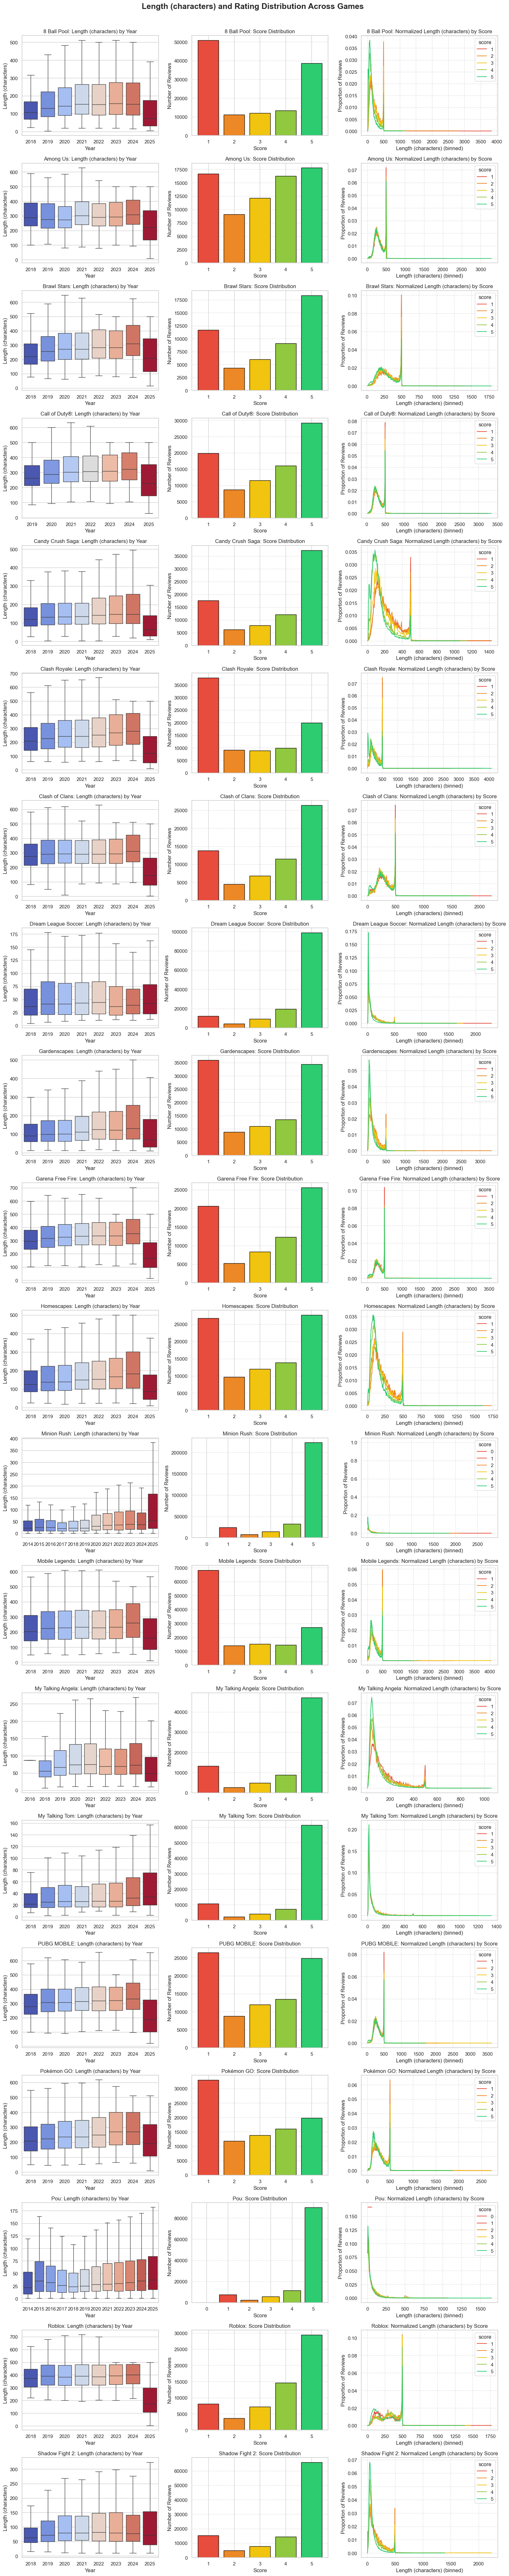

In [9]:
games = sorted(data["game_name"].unique())
fig, axes = plt.subplots(len(games), 3, figsize=(16, 4 * len(games)))

sns.set(style="whitegrid")
rating_colors = LinearSegmentedColormap.from_list("rating_colormap", ["#e74c3c", "#f1c40f", "#2ecc71"], N=5)

for i, app_name in enumerate(games):
    game_data = data[data["game_name"] == app_name].copy()
    if game_data.empty:
        for j in range(3):
            axes[i][j].axis("off")
        continue

    # --- preprocess ---
    game_data["length"] = game_data["content"].astype(str).str.len()
    game_data["word_count"] = game_data["content"].astype(str).str.split().str.len()

    # --- 1️⃣ Length (characters) by year ---
    sns.boxplot(
        x="year", y="length", hue="year",
        data=game_data, palette="coolwarm",
        showfliers=False, legend=False, ax=axes[i][0]
    )
    axes[i][0].set_title(f"{app_name}: Length (characters) by Year")
    axes[i][0].set_xlabel("Year")
    axes[i][0].set_ylabel("Length (characters)")

    # --- 2️⃣ Score distribution ---
    score_count = game_data["score"].value_counts().sort_index()
    axes[i][1].bar(
        score_count.index,
        score_count.values,
        color=[rating_colors((s - 1) / 4) for s in score_count.index],
        edgecolor="black"
    )
    axes[i][1].set_title(f"{app_name}: Score Distribution")
    axes[i][1].set_xlabel("Score")
    axes[i][1].set_ylabel("Number of Reviews")
    axes[i][1].grid(axis="y", linestyle="--", alpha=0.6)

    # --- 3️⃣ Normalized Length (characters) distribution ---
    bins = np.arange(0, game_data["length"].max() + 5, 5)
    game_data["word_bin"] = pd.cut(game_data["length"], bins)

    counts = (
        game_data.groupby(["word_bin", "score"], observed=True)
        .size().reset_index(name="count")
    )
    total_per_score = counts.groupby("score")["count"].transform("sum")
    counts["normalized"] = counts["count"] / total_per_score
    counts["word_mid"] = counts["word_bin"].apply(lambda x: x.mid)

    sns.lineplot(
        data=counts,
        x="word_mid",
        y="normalized",
        hue="score",
        palette=[rating_colors((s - 1) / 4) for s in sorted(counts["score"].unique())],
        ax=axes[i][2]
    )
    axes[i][2].set_title(f"{app_name}: Normalized Length (characters) by Score")
    axes[i][2].set_xlabel("Length (characters) (binned)")
    axes[i][2].set_ylabel("Proportion of Reviews")
    axes[i][2].grid(True, linestyle="--", alpha=0.6)

# --- layout ---
plt.tight_layout()
plt.suptitle("Length (characters) and Rating Distribution Across Games", fontsize=18, fontweight="bold", y=1.008)
plt.show()